# Manuscript plots

In [1]:
import os
import tqdm
import pickle
import numpy as np
import networkx as nx

import seaborn as sns
from scipy.stats import beta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.collections as mcoll
import matplotlib.animation as animation

from time import time
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap

from model_optimized import run_model_n_times
from experiment_utils import get_distribution,get_development_matrix,findIntersection

from plotting_utils import plot_model_summary,plot_network_development_summary,plot_stage_distribution
from plotting_utils import plot_development,plot_neighbors

___

## Types of networks
A simple plot with different types of network topologies, for the method section

/home/admin/Escritorio/Thesis_Models/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


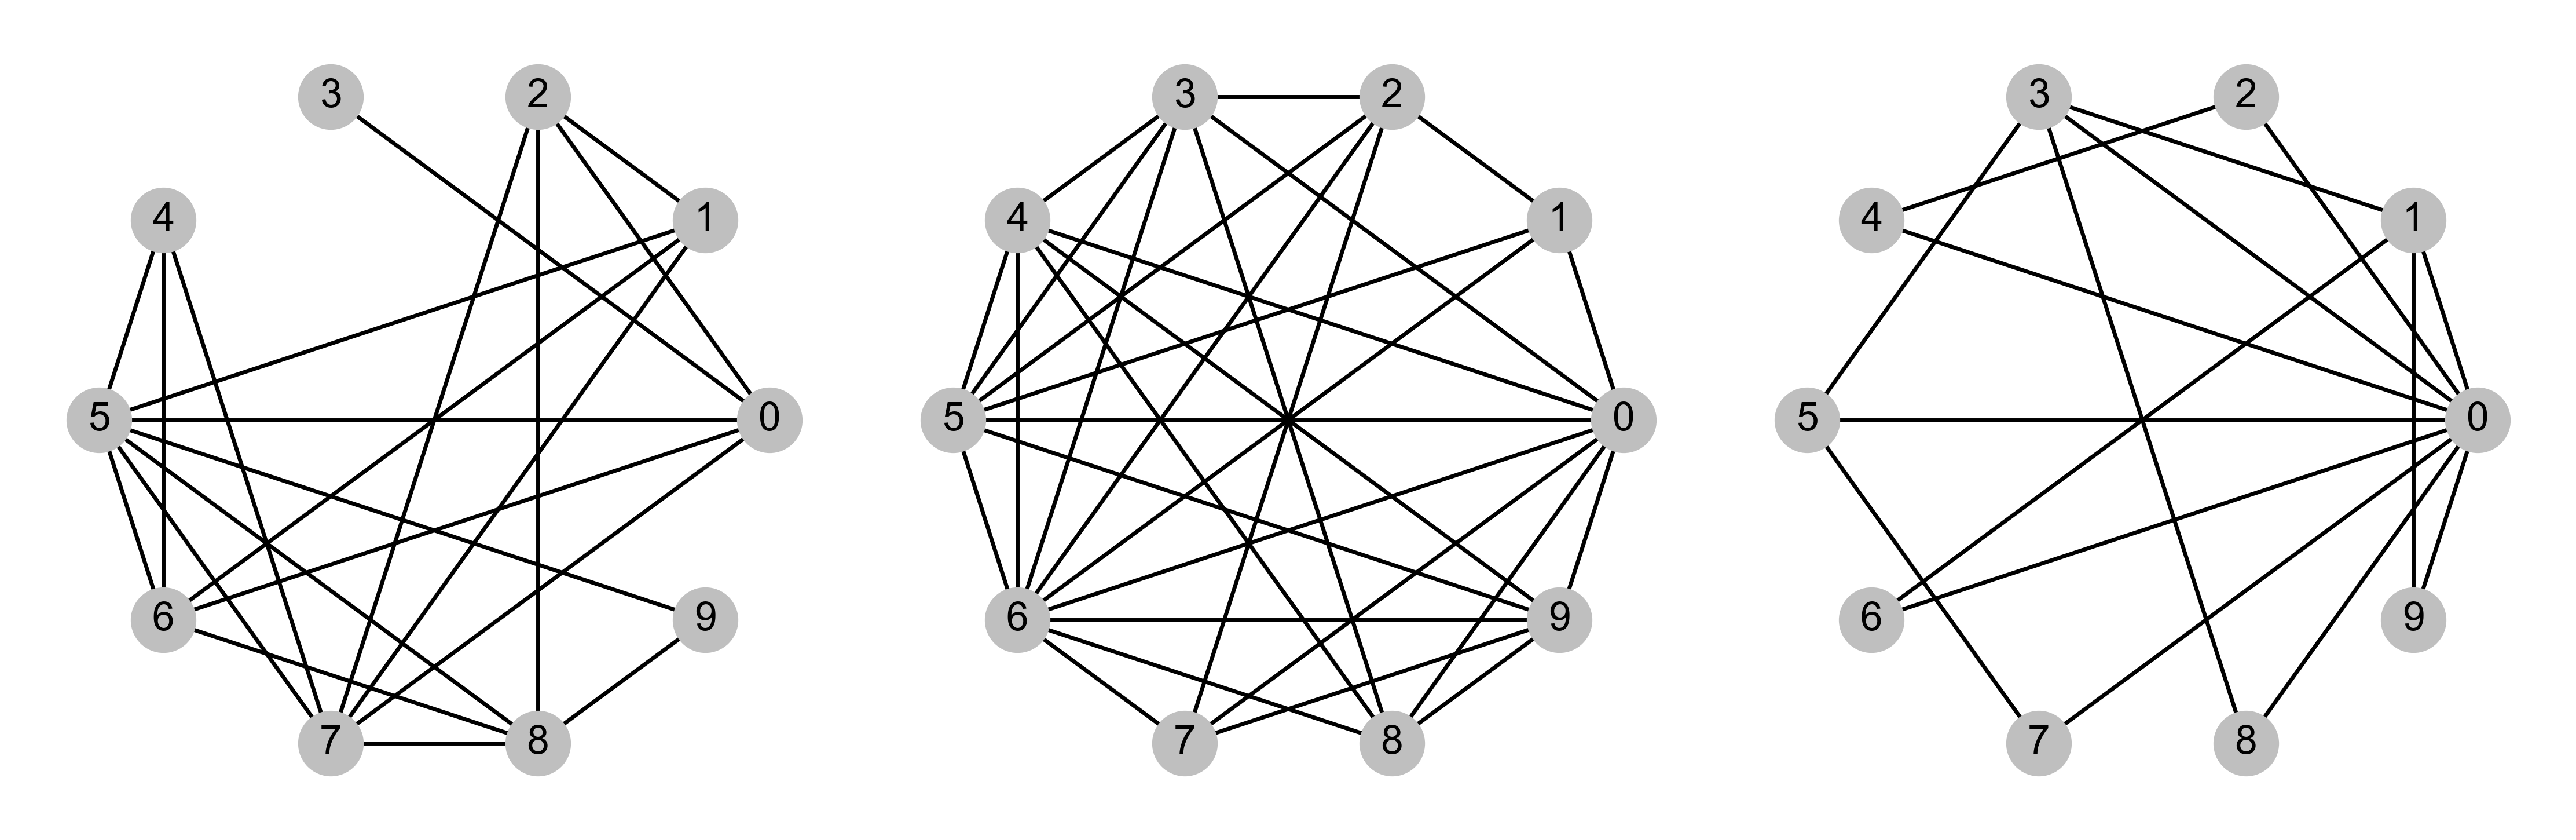

In [196]:
dpi = 500

# Network size
N = 10

# Network seed
seed_network = 30

# Network parameters
p_random = 0.3
p_smallw = 0.6
k_smallw = 6
m = 2

# Generate networks: random, small world, scale
network_random = nx.erdos_renyi_graph(n=N, p=p, seed=seed_network)
network_smallw = nx.watts_strogatz_graph(n=N, k=k_smallw, p=p_smallw, seed=seed_network)
network_scalef = nx.barabasi_albert_graph(n=N, m=m,seed=seed_network)
networks = [network_random,network_smallw,network_scalef]
titles = ['Random','Small World','Scale-Free']

# Plot them!
fig, axs = plt.subplots(1, 3, figsize=(9, 3),sharex=True,sharey=True,dpi=dpi)
for i in range(3):
    this_network = networks[i]
    pos = nx.circular_layout(this_network)

    node_color = (0.75,0.75,0.75)
    nx.draw_networkx(this_network, 
                    ax=axs[i], 
                    pos=pos, 
                    with_labels=True, 
                    node_color=node_color,
                    node_size=250,
                    font_size=10,
                    linewidths=0.5)

    # Remove axis box
    axs[i].axis('off')

# Save the plot
plt.tight_layout()
plt.savefig(f'./Secondary_plots/networks.jpg', dpi=dpi)

___

## Beta distributions
A plot with different Beta distributions

/tmp/ipykernel_661/3232411232.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "tab:green" (-> color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)). The keyword argument will take precedence.
  plt.plot(x, y,'tab:green', lw=2, alpha=0.8, color=c,label=f'$ \mu={beta_means[d]}$') #f'a={round(a,2)},b={round(b,2)}')


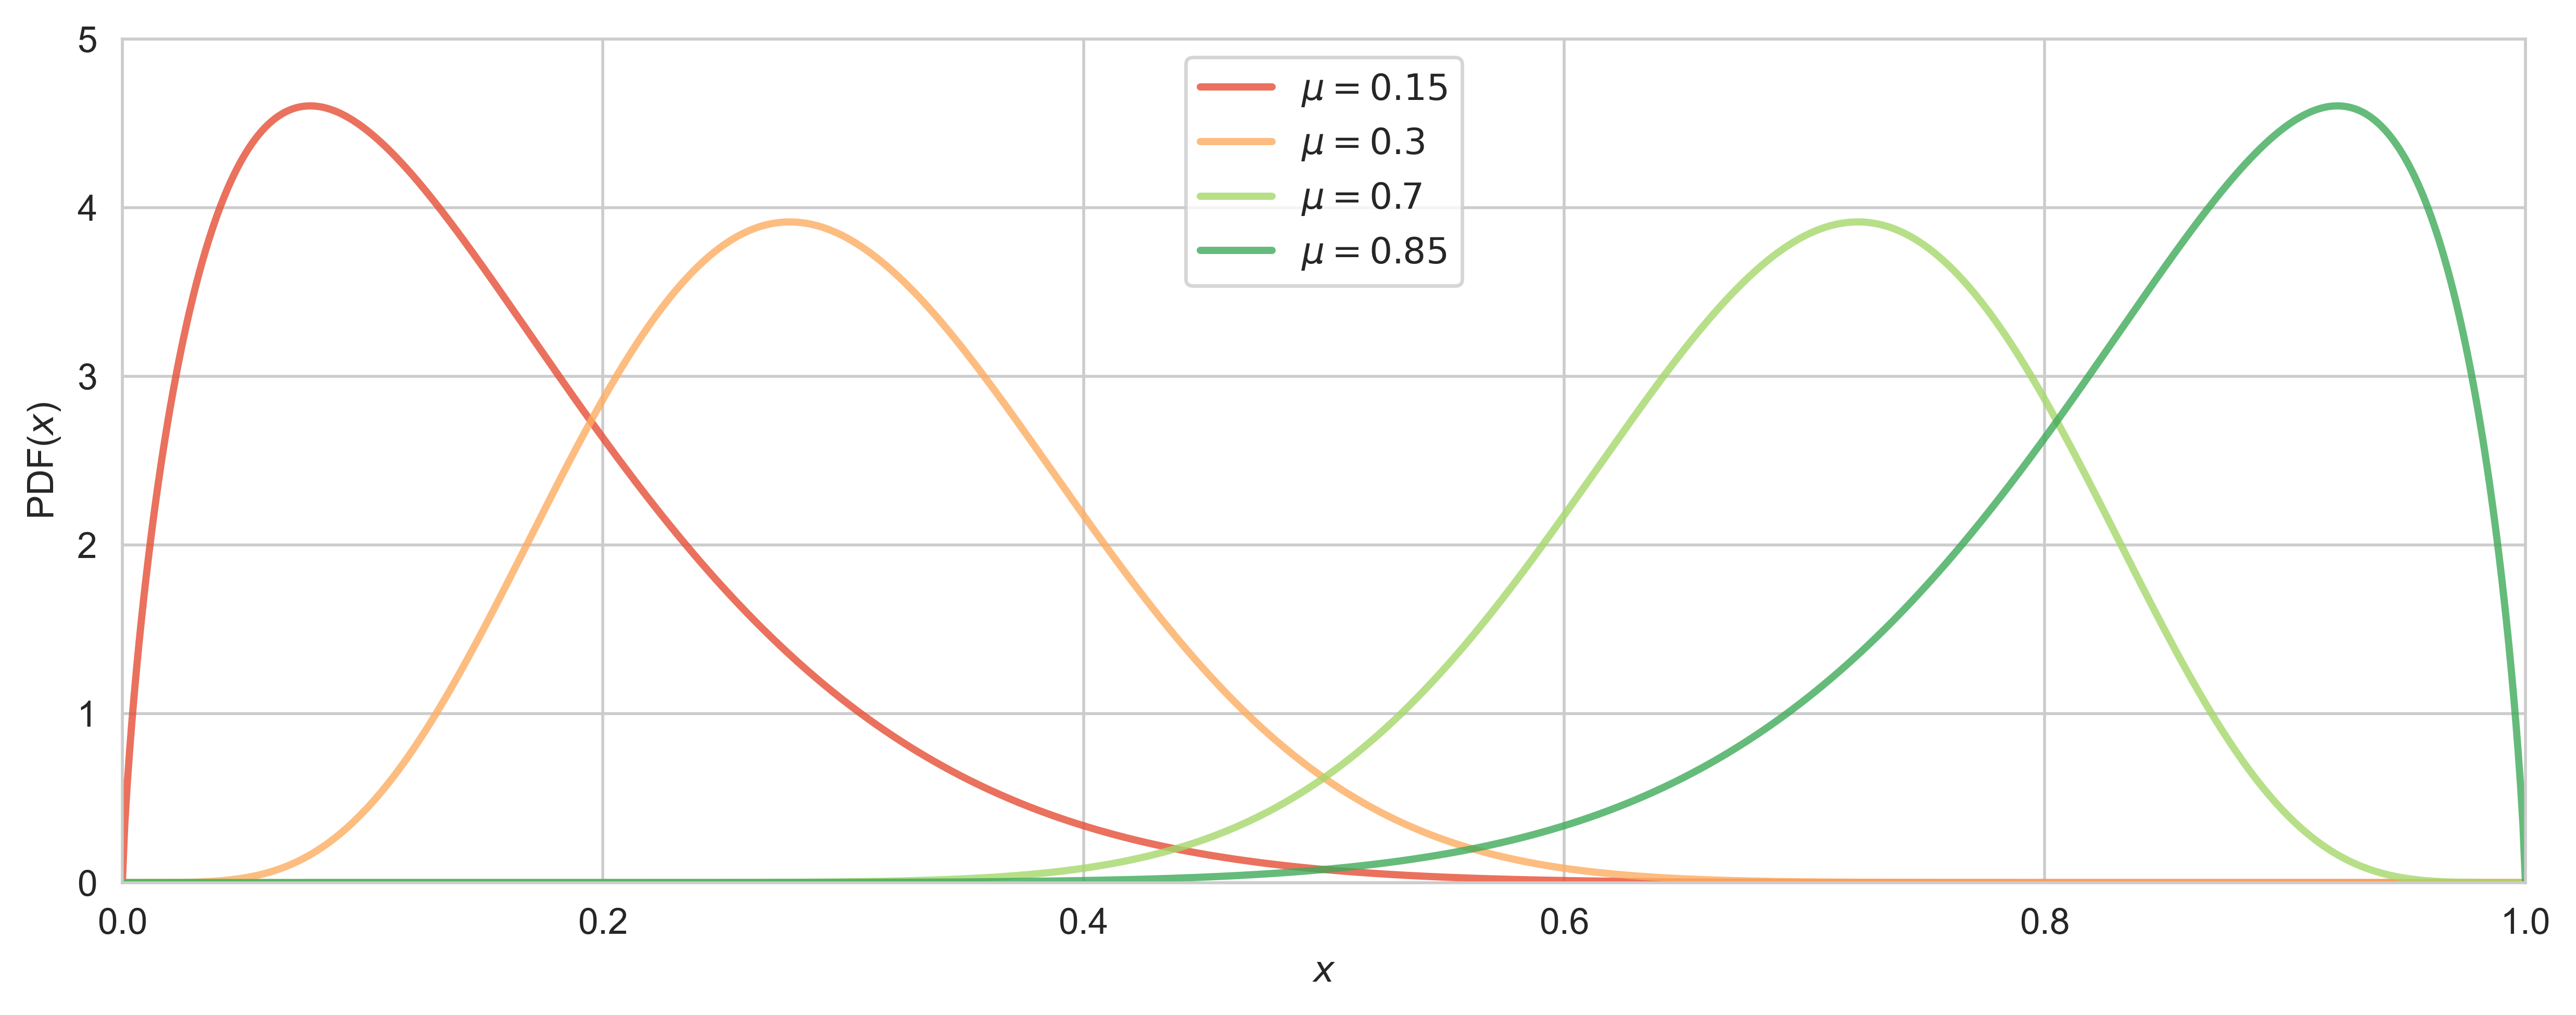

In [198]:
dpi = 500
plt.figure(figsize=(10, 4),dpi=dpi)

beta_means = [0.15,0.3,0.7,0.85]
variance = 0.01

N_distribs = len(beta_means)

# Beta distribution
distributions_beta = np.zeros((N_distribs,N))
beta_variances = variance*np.ones(N_distribs)

# Tolerance for fitting the distribution 
tolerance = 1e-12

# Logging values of actual distribution
beta_alphas = np.zeros(N_distribs)
beta_betas  = np.zeros(N_distribs)

# Obtain the distributions
for d in range(N_distribs):
    distribution_parameters = get_distribution(beta_means[d],beta_variances[d],tolerance)
    beta_alphas[d] = distribution_parameters['alpha']
    beta_betas[d] = distribution_parameters['beta']
    distributions_beta[d,:] =  get_development_matrix(distribution_parameters,N)

# Create entry on dictionary
distributions_beta

# Have alphas and betas
for d in range(N_distribs):
    a = beta_alphas[d]
    b = beta_betas[d]
    
    x = np.linspace(0,1,1000)
    y = beta.pdf(x,a,b)

    # Plot color
    c = plt.cm.RdYlGn(beta_means[d])

    plt.plot(x, y,'tab:green', lw=2, alpha=0.8, color=c,label=f'$ \mu={beta_means[d]}$') #f'a={round(a,2)},b={round(b,2)}')

    # Vertical line 
    x = beta_means[d]
    y = beta.pdf(x,a,b)

plt.xlim([0,1])
plt.ylim([0,5])
plt.xlabel('$x$')
plt.ylabel('PDF($x$)')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'./Secondary_plots/beta_distributions.jpg', dpi=dpi)


## Developmental pathway

In [4]:
from experiment_utils import get_individual_morality,get_susceptibility,get_society_bias,get_agent_stage

dpi = 500

m0 = 0.1
m1 = 0.9
theta_x = 0.5
theta_y = 1

d12,m12 = findIntersection(0,0,theta_x,theta_y,0,m0,1,m1)
d23,m23 = findIntersection(theta_x,theta_y,1,0,0,m0,1,m1)

model = {
    'm0': m0,
    'm1': m1,
    'theta_x': theta_x,
    'theta_y': theta_y,
    'm12' : m12,
    'm23' : m23
}

points_plotting = 10000
sns.set_style("whitegrid")
plt.figure(figsize=(8,3),dpi=1500)

x = np.linspace(0,1,points_plotting)
y_individual = np.zeros(points_plotting)
y_group = np.zeros(points_plotting)
y_society = np.zeros(points_plotting)

for i in range(points_plotting):
    y_individual[i] = get_individual_morality(x[i],model['m0'],model['m1'])
    y_group[i] = get_susceptibility(x[i],model['theta_x'],model['theta_y'])

color_m = (0.72,0.27,0.16)
color_s = (0.79,0.84,0.91)

plt.plot(x,y_individual,label='$p_m$($d_a$)',lw=2,zorder=3,c=color_m)
plt.plot(x,y_group,label='$s$($d_a$)',lw=2,zorder=3,c=color_s)
color_lines = (0.82,0.82,0.82)

plt.xlim([0,1])
plt.ylim([0,1.1])

plt.legend()
plt.xlabel('$d_a$')
plt.ylabel('Value')
plt.tight_layout()

color_dots = (0.35,0.35,0.35)
idx = np.argwhere(np.diff(np.sign(y_group - y_individual))).flatten()
plt.plot(x[idx], y_group[idx], 'ro',zorder=4,c=color_dots)
plt.plot(model['theta_x'],model['theta_y'], 'ro',zorder=4,c=color_dots)

# Egocentric to Ethnocentric / Ethnocentric to Worldcentric
M12 = x[idx][0]
M23 = x[idx][1]

# Axis ticks
xtiks = [0,M12,0.25,0.4,theta_x,0.6,M23,0.75,0.88,1]
plt.xticks(xtiks,[str(round(i,2)) for i in xtiks])

ytiks = [0,0.1,m12,0.5,m23,0.8,1]
plt.yticks(ytiks,[str(round(i,2)) for i in ytiks])

plt.grid(axis='both',color=(0.85,0.85,0.85))    

plt.legend()
plt.tight_layout()
plt.savefig(f'./Secondary_plots/MD_pathway.jpg', dpi=dpi)

/tmp/ipykernel_2343/3611754215.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x[idx], y_group[idx], 'ro',zorder=4,c=color_dots)
/tmp/ipykernel_2343/3611754215.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(model['theta_x'],model['theta_y'], 'ro',zorder=4,c=color_dots)


___